# Walking through District Heating Pipe Predictive Maintenance

### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib import style
# import pickle
import dhc_maintenance.toolkit as toolkit
import dhc_maintenance.simulation as simulation
import dhc_maintenance.maintenance as maintenance
# from matplotlib.animation import FuncAnimation
# import matplotlib.animation as animation
# import os
import dhc_maintenance.pipe as pipe
# from cProfile import label
# import chart_studio.plotly as py
# import plotly.graph_objs as go
# import plotly as plotly
# import numpy as np
# import matplotlib.pylab as plt
# from imblearn.over_sampling import SMOTE
# from imblearn.over_sampling import SMOTENC
# import xgboost as xgb
from xgboost.sklearn import XGBClassifier
# from sklearn import metrics
# from sklearn.preprocessing import LabelEncoder
# import types
# import seaborn as sns
# from datetime import datetime
# from scipy import stats
# from IPython import display


## Backward simulation

##### To ensure effective predictive maintenance of DH pipes, the loading history on the pipes must be taken into consideration.This entails the acquisition of temperature change data for the entirety of the pipe's service life. However, such data is often unavailable as certain pipes have been in operation for over three decades. To address this issue, it becomes necessary to backward simulate the temperature change history . For this reason, it is required to have a minimum of recent 3 years of temperature changes of the network.It is presumed that the input data files are already cleaned and prepared as in the data folder.

In [2]:
# Instantiating a utilit instance and name it as network
network = simulation.Utility()

In [3]:
# It is possible to check all the list of available weather station in Germany
network.weather.dwd

,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland
Stations_id,,,,,,,
00003,19500401,20110331,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
00044,20070401,20230215,44,52.9336,8.2370,Großenkneten,Niedersachsen
00052,19760101,19880101,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein
00071,20091201,20191231,759,48.2156,8.9784,Albstadt-Badkap,Baden-Württemberg
00073,20070401,20230215,340,48.6159,13.0506,Aldersbach-Kriestorf,Bayern
...,...,...,...,...,...,...,...
15555,20160501,20230215,815,47.8761,10.5849,Kaufbeuren-Oberbeuren,Bayern
15813,20220301,20230215,40,52.5126,7.4131,Lingen-Baccum,Niedersachsen
19171,20200901,20230215,13,54.0039,9.8555,Hasenkrug-Hardebek,Schleswig-Holstein


In [4]:
# In this example we assume that the network is located in the city of Hamburg
# By giving the name of the city in the search_station_ID method, it is possible
# to acquire the list of the stations of the designated city from the
# Deutscher Wetterdienst (DWD)
# Here we can see three main station of the hamburg and it we can see which one
# is have more data history.
network.weather.search_station_ID('hamburg')

,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland
Stations_id,,,,,,,
01975,19490101,20230215,11,53.6332,9.9881,Hamburg-Fuhlsbüttel,Hamburg
01981,20050301,20230215,3,53.4777,9.8957,Hamburg-Neuwiedenthal,Hamburg
06254,20020101,20070702,19,53.5408,9.9528,Hamburg-Lotsenhöft,Hamburg


In [5]:
# The station Id 01975 could be given to the load_weather method to
# be downloaded and inserted in the network object.
network.weather.load_weather("01975")

In [6]:
# Now it is possible to take a look at the imported weather data.
# The software will take care of the cleaning the NaNs and sorting the dates
# at a later stage
network.weather.data

,Out_Temp,Hum,Cloud_Cover,Precipitaion_height,Precipitation_index,Precipitation_form,Sunshine_Duration,Mean_Wind_Spdeed,Month,Hour,Off_Days
MESS_DATUM,,,,,,,,,,,
1949-01-01 01:00:00,2.1,82.0,8.0,NaN,NaN,NaN,NaN,NaN,1,1,1
1949-01-01 02:00:00,3.0,79.0,8.0,NaN,NaN,NaN,NaN,NaN,1,2,1
1949-01-01 03:00:00,3.7,75.0,0.0,NaN,NaN,NaN,0.0,NaN,1,3,1
1949-01-01 04:00:00,3.3,75.0,4.0,NaN,NaN,NaN,0.0,NaN,1,4,1
1949-01-01 05:00:00,2.7,75.0,5.0,NaN,NaN,NaN,0.0,NaN,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...
1973-02-21 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.8,2,23,0
1973-02-22 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.7,2,1,0
1973-02-22 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.6,2,2,0


In [7]:
# Also it is neccessary to load the network temperature time series
# The method load_tempereture_changes is responsible for that
network.load_temperature_changes("data/temperature_dummy.csv")

In [8]:
# It is possible to check the imported network data
network.temperature_changes

,Supply,Return
MESS_DATUM,,
2018-01-01 00:00:00,90.82,55.27
2018-01-01 01:00:00,96.31,59.10
2018-01-01 02:00:00,90.47,57.23
2018-01-01 03:00:00,97.99,58.30
2018-01-01 04:00:00,93.68,57.30
...,...,...
2021-12-31 19:00:00,87.13,57.03
2021-12-31 20:00:00,86.61,55.07
2021-12-31 21:00:00,89.77,58.10


In [9]:
# Some inconsistancy checks on weather data
network.weather.data.index.is_unique

True

In [10]:
# Some inconsistancy checks on network temperature data
network.temperature_changes.index.is_unique

True

In [11]:
# Puting network temeprature data and weather data
# according to their date-time together
network.concat()
network.data.tail()

,Supply,Return,Out_Temp,Hum,Cloud_Cover,Precipitaion_height,Precipitation_index,Precipitation_form,Sunshine_Duration,Mean_Wind_Spdeed,Month,Hour,Off_Days
MESS_DATUM,,,,,,,,,,,,,
2021-12-31 19:00:00,87.13,57.03,11.9,96.0,8.0,0.6,1.0,6.0,0.0,5.9,12,19,0
2021-12-31 20:00:00,86.61,55.07,11.8,95.0,8.0,1.2,1.0,6.0,0.0,5.2,12,20,0
2021-12-31 21:00:00,89.77,58.10,11.7,96.0,8.0,0.4,1.0,-999.0,NaN,5.2,12,21,0
2021-12-31 22:00:00,84.00,55.10,11.7,94.0,8.0,0.0,1.0,6.0,NaN,5.8,12,22,0
2021-12-31 23:00:00,86.30,55.10,11.7,93.0,8.0,0.1,1.0,6.0,NaN,5.4,12,23,0


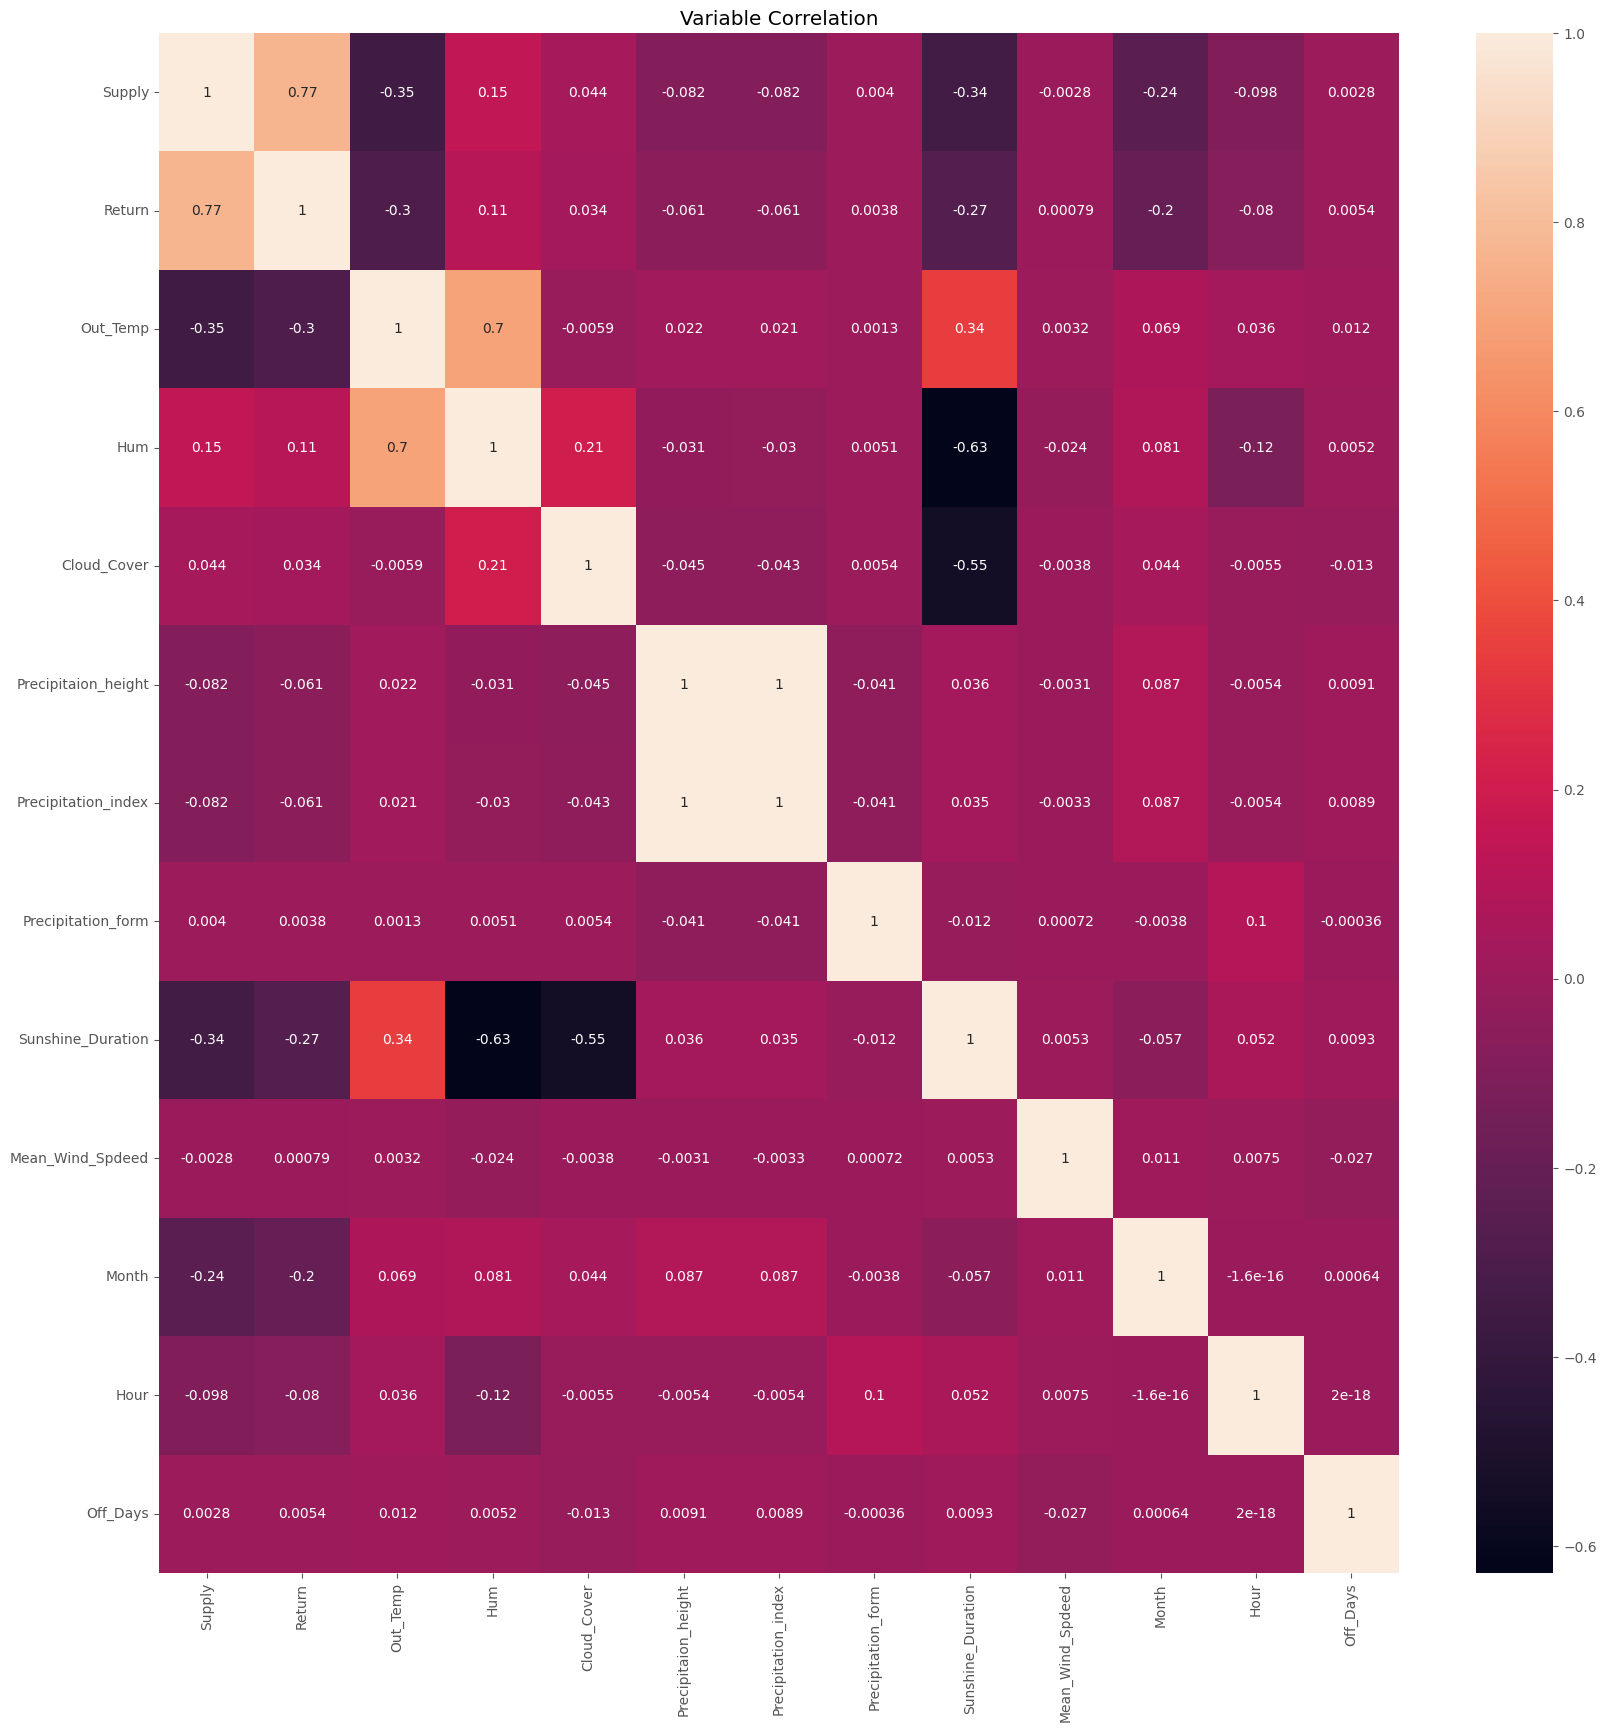

In [12]:
# the corr method will plot the correlation of our vrabiales
# this will make it easy for us for feature selection
network.corr()

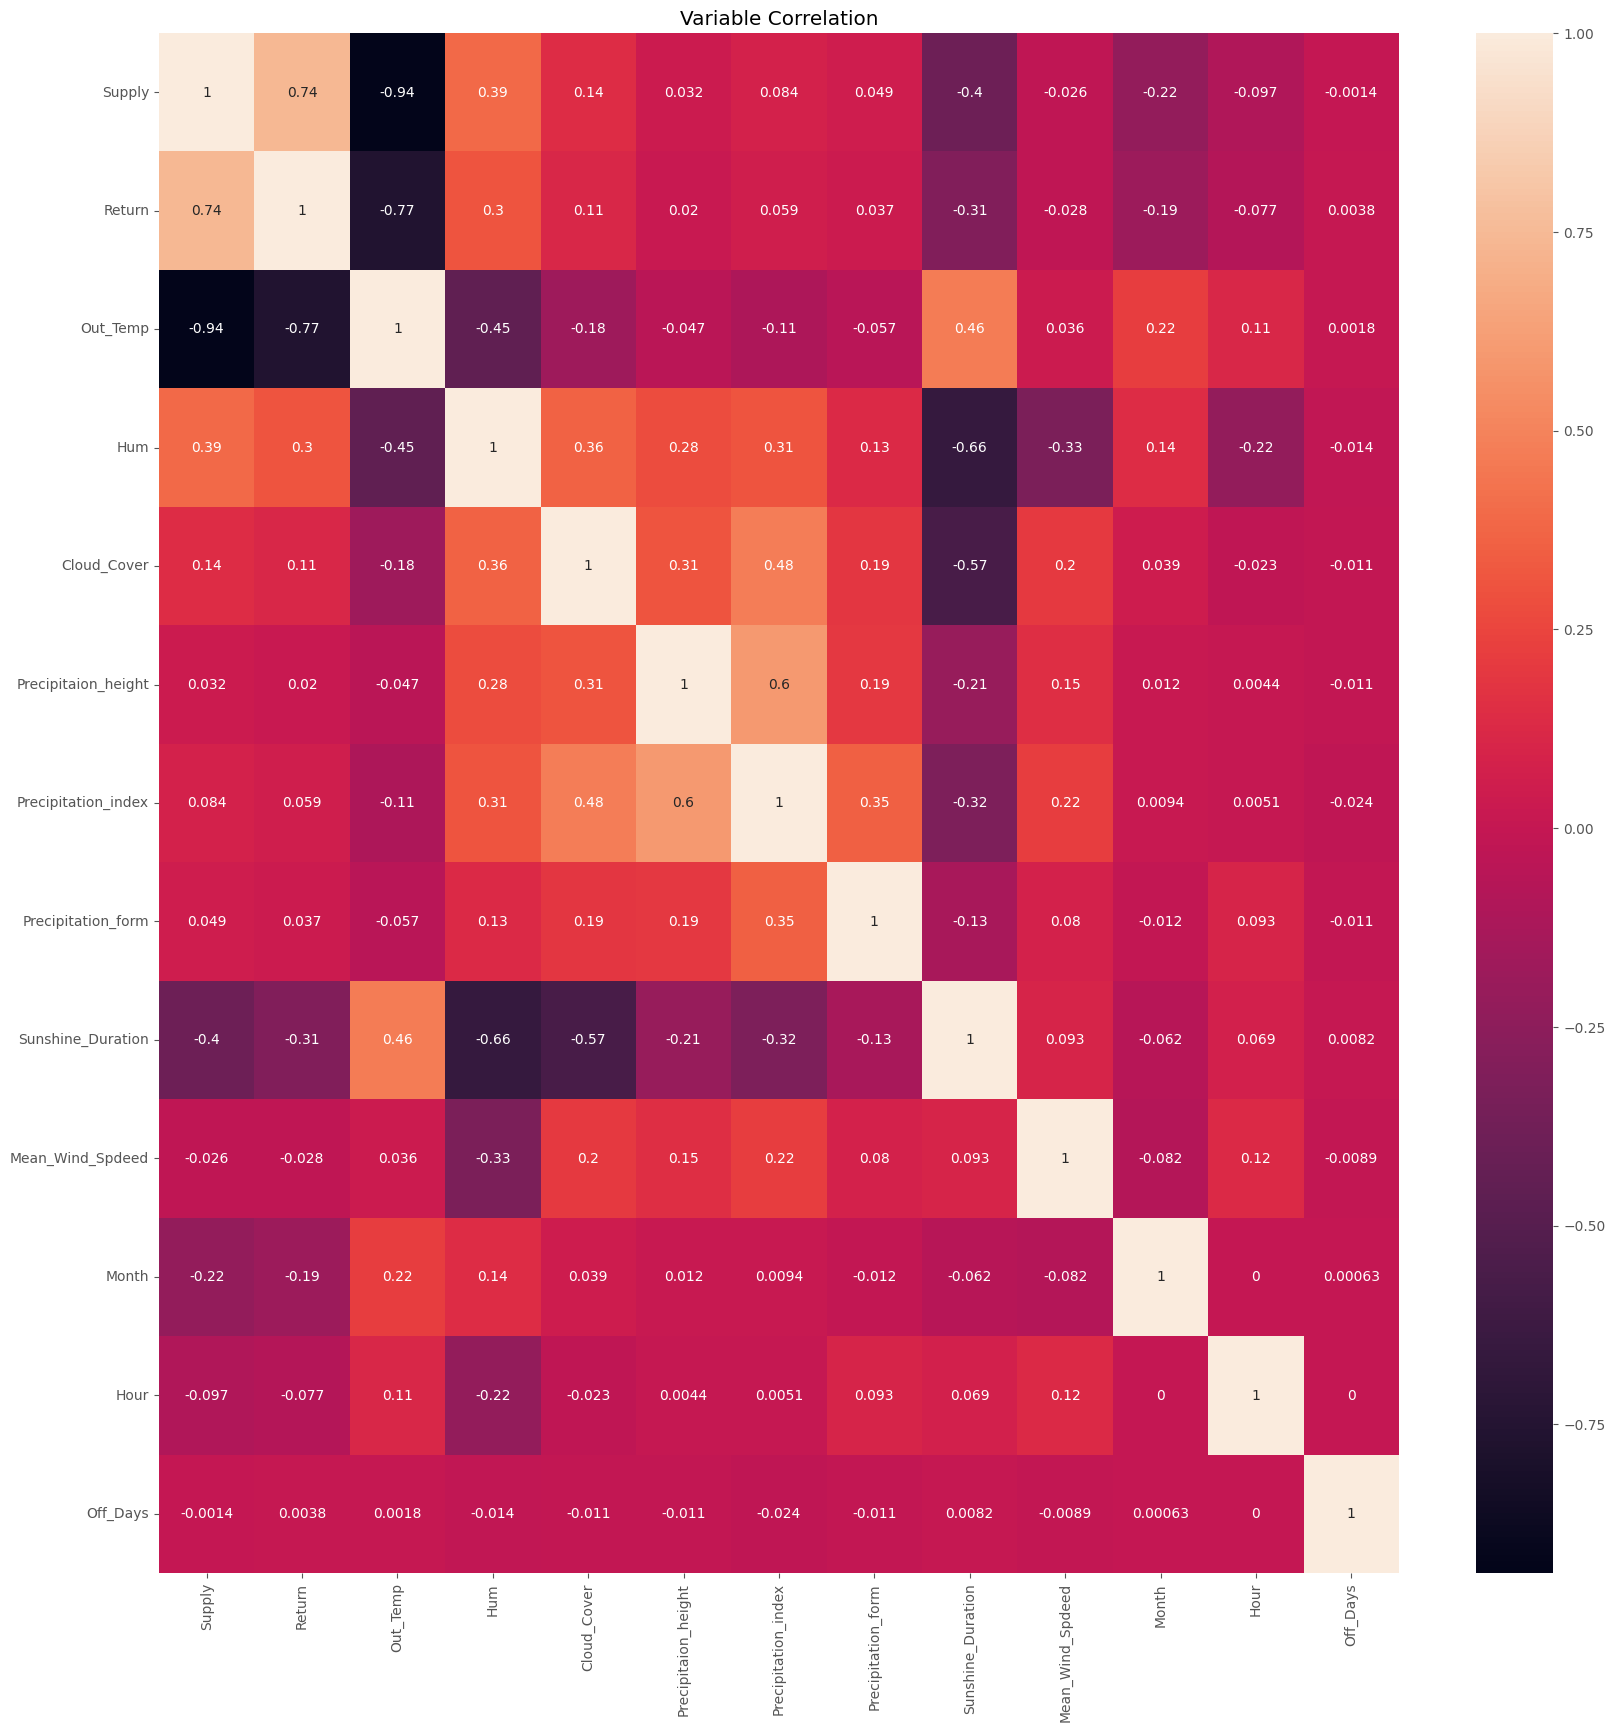

In [13]:
# aslo it is possible to choose between pearson and spearman
# the default is pearson
network.corr("spearman")

In [14]:
# based on our correlation plot we can drop the not intereted
# features and clean the datafram (nan values) for our training
col_list = ['Precipitaion_height', 'Precipitation_index', 'Precipitation_form']
network.drop_clean(col_list)

In [15]:
# This method will backward simulate up to the availabe
# historical temperature data
network.simulate()

Simulation done: Data in self.simulation, .return_simulate, .supply_simulate


In [16]:
# Now there are simulated time sereies of network temperature
# with a length of the entire weather data
network.simulation

,Supply,Return
MESS_DATUM,,
1949-01-01 01:00:00,105.6817,59.3287
1949-01-01 02:00:00,105.4235,59.4012
1949-01-01 03:00:00,101.9169,58.6271
1949-01-01 04:00:00,103.2086,58.9412
1949-01-01 05:00:00,105.2949,59.3479
...,...,...
2021-12-31 19:00:00,86.8673,56.4784
2021-12-31 20:00:00,86.7147,55.8295
2021-12-31 21:00:00,88.3150,57.1746


In [17]:
# The optimize method is in testing phase now
# it is not necessary to run
network.optimize()

optimization done


In [18]:
# It is possible to check the training accuracy
print(network.supply_simulate.trainer.accuracy)
print(network.return_simulate.trainer.accuracy)

0.930840940913697
0.6153638318298655


In [19]:
len(network.supply_training_set[1])

35064

## Forming inventory dataframe

In [20]:
# Import inventory csv file and form a dataframe
path = "data/inventory_dummy.csv"
with open(path, 'r') as inventory:
    inventory = pd.read_csv(inventory,
                            index_col=0,
                            converters={"Failure Year": lambda x: [int(i.strip("[]").replace('"','')) for i in x.split(",")],
                                        "Failure Degree": lambda x: x.strip("[]").replace("'","").split(", "),
                                        "Failure Types": lambda x: x.strip("[]").replace("'","").split(", "),
                                        },
                            )

In [21]:
# In this data set only pipe type pre-insulated bounded pipe
# (Kunststoffmantelrohr/ KMR) exist
inventory.head()

,Type,ID,DN,Laying System,Length,Flow,Build Year,Connection,Life Status,Failure Year,Failure Degree,Failure Types,Decommission Year
0,KMR,761856,65,Burried,4,Return,1998,House,InOperation,[0],[NoFailure],[NoFailure],0
1,KMR,741382,65,Burried,15,Supply,2019,Line,InOperation,[0],[NoFailure],[NoFailure],0
2,KMR,172046,50,Burried,18,Return,1980,Line,Decommissioned,[0],[NoFailure],[NoFailure],2023
3,KMR,258063,32,Burried,19,Supply,2019,Line,InOperation,[0],[NoFailure],[NoFailure],0
4,KMR,260128,150,Burried,119,Return,1984,Line,InOperation,[0],[NoFailure],[NoFailure],0


In [22]:
# The class pipe is responsible for calculations of the loading on the pipe
# It is possible to instantiate a pipe object with the following parameters:
# ID, TYPE, medium_count, dn, laying, length, flow, build_year, connection
# life_status, failure_years, failure_degrees, failure_types, decommission_year
pipe1 = pipe.KMR(
    ID=123456,
    TYPE=pipe.PipeSystem["KMR"],
    medium_count=pipe.MedPipeCount(1),
    dn=150,
    laying=pipe.LayingSystem["Burried"],
    length=10,
    flow=pipe.Flow["Supply"],
    build_year=1988,
    connection=pipe.PipeConnection["Line"],
    life_status=pipe.Status["InOperation"],
    failure_years=[2007],
    failure_degrees=[pipe.FailureLevels["Substantial"]],
    failure_types=[pipe.FailureType["Fatigue"]],
    decommission_year=0,
)

In [23]:
# Evaluate method will calculate all the parameteres require for
# ageing of the pipe
pipe1.evaluate(network)
# Afterward it is possible to read all the parameters as with text or enumaration
# If no parameter is given the output is as the text
pipe1.dataframe(format="name")

,ID,Type,Medium Pipe Mode,DN,DNCat,Laying System,Length,Flow,Build_Year,Connection,Life_Status,Failures,Status_at_Failure,Failure_Year,Failure_Count,Failure_Degree,Failure_Types,Decommission_Year,Age,Aged,Age_at_Failure,Age_at_Decommission,EFLC,Fatigue,Temperature_Background,Temperature_Min,Temperature_Max,Temperature_Means,Temperature_Median,PUR Age,Augmented,Condition,ΔT 1,ΔT 2,ΔT 3,ΔT 4,ΔT 5,ΔT 6,ΔT 7,ΔT 8,ΔT 9,ΔT 10,ΔT 11,ΔT 12,ΔT 13,ΔT 14,ΔT 15,ΔT 16,ΔT 17,ΔT 18,ΔT 19,ΔT 20,ΔT 21,ΔT 22,ΔT 23,ΔT 24,ΔT 25,ΔT 26,ΔT 27,ΔT 28,ΔT 29,ΔT 30,ΔT 31,ΔT 32,ΔT 33,ΔT 34,ΔT 35,ΔT 36,ΔT 37,ΔT 38,ΔT 39,ΔT 40,ΔT 41,ΔT 42,ΔT 43,ΔT 44,ΔT 45,ΔT 46,ΔT 47,ΔT 48,ΔT 49,ΔT 50,ΔT 51,ΔT 52,ΔT 53,ΔT 54,ΔT 55,ΔT 56,Max_ΔT,Mean_Cycle,Failure_Target
0,123456,KMR,Single,150,M,Burried,10,Supply,1988,Line,InOperation,Damaged,InOperation,2007,1,Substantial,Fatigue,0,35,Aged,19,0,4.947799,0.000048,77,77,133,93,91,0.026337,0,good,23838.0,9689.0,3245.0,1243.5,730.0,612.0,492.5,470.0,381.0,370.0,366.0,310.0,271.0,260.5,232.0,213.0,177.0,173.0,110.0,138.0,123.0,97.0,59.0,54.5,47.0,40.0,43.0,35.0,20.0,19.0,22.0,24.0,14.5,11.0,14.0,9.0,6.5,6.0,10.0,3.0,5.0,4.0,4.0,2.0,2.5,2.5,3.0,0.0,0.0,1.0,4.0,0.0,0.0,2.0,7.0,3.0,56,2524.230769,1


In [24]:
# Aslo it is possible to generate the dataframe based
# on numeric values with passing the argument format="value"
pipe1.dataframe("value")

,ID,Type,Medium Pipe Mode,DN,DNCat,Laying System,Length,Flow,Build_Year,Connection,Life_Status,Failures,Status_at_Failure,Failure_Year,Failure_Count,Failure_Degree,Failure_Types,Decommission_Year,Age,Aged,Age_at_Failure,Age_at_Decommission,EFLC,Fatigue,Temperature_Background,Temperature_Min,Temperature_Max,Temperature_Means,Temperature_Median,PUR Age,Augmented,Condition,ΔT 1,ΔT 2,ΔT 3,ΔT 4,ΔT 5,ΔT 6,ΔT 7,ΔT 8,ΔT 9,ΔT 10,ΔT 11,ΔT 12,ΔT 13,ΔT 14,ΔT 15,ΔT 16,ΔT 17,ΔT 18,ΔT 19,ΔT 20,ΔT 21,ΔT 22,ΔT 23,ΔT 24,ΔT 25,ΔT 26,ΔT 27,ΔT 28,ΔT 29,ΔT 30,ΔT 31,ΔT 32,ΔT 33,ΔT 34,ΔT 35,ΔT 36,ΔT 37,ΔT 38,ΔT 39,ΔT 40,ΔT 41,ΔT 42,ΔT 43,ΔT 44,ΔT 45,ΔT 46,ΔT 47,ΔT 48,ΔT 49,ΔT 50,ΔT 51,ΔT 52,ΔT 53,ΔT 54,ΔT 55,ΔT 56,Max_ΔT,Mean_Cycle,Failure_Target
0,123456,2,1,150,1,2,10,1,1988,1,1,1,1,2007,1,2,2,0,35,1,19,0,4.947799,0.000048,77,77,133,93,91,0.026337,0,2,23838.0,9689.0,3245.0,1243.5,730.0,612.0,492.5,470.0,381.0,370.0,366.0,310.0,271.0,260.5,232.0,213.0,177.0,173.0,110.0,138.0,123.0,97.0,59.0,54.5,47.0,40.0,43.0,35.0,20.0,19.0,22.0,24.0,14.5,11.0,14.0,9.0,6.5,6.0,10.0,3.0,5.0,4.0,4.0,2.0,2.5,2.5,3.0,0.0,0.0,1.0,4.0,0.0,0.0,2.0,7.0,3.0,56,2524.230769,1


In [25]:
# create our pipe objects in a dictionary 
object_inventory = {}
# in this analysis we are interested in Kunststoffmantelrohr

for i in range(1000):
    # Useing KMR class to instantiate pipe objects
    object_inventory["HH-" + str(inventory.iloc[i]['ID'])] = pipe.KMR(
    ID=inventory.iloc[i]['ID'],
    TYPE=pipe.PipeSystem[inventory.iloc[i]['Type']],
    medium_count=pipe.MedPipeCount(1),
    dn=inventory.iloc[i]['DN'],
    laying=pipe.LayingSystem[inventory.iloc[i]['Laying System']],
    length=inventory.iloc[i]['Length'],
    flow=pipe.Flow[inventory.iloc[i]['Flow']],
    build_year=inventory.iloc[i]['Build Year'],
    connection=pipe.PipeConnection[inventory.iloc[i]['Connection']],
    # here we set 10% chance that the pipe is decomissioned
    life_status=pipe.Status[inventory.iloc[i]['Life Status']],
    failure_years=inventory.iloc[i]['Failure Year'],
    failure_degrees=[pipe.FailureLevels[inventory.iloc[i]['Failure Degree'][0]]],
    failure_types=[pipe.FailureType[inventory.iloc[i]['Failure Types'][0]]],
    decommission_year=inventory.iloc[i]['Decommission Year'],
    )


In [26]:
# SOme inconsistancy check
# This takes a while
exeptions = []
for key, value in object_inventory.items():
    try:
        value.evaluate(network)
    except Exception as e:
        exeptions.append(key)
        #print(value.ID)
        print(e)

In [27]:
# printing out exeptions if any
exeptions

[]

In [28]:
# remove the expetions from the inventory
if exeptions:
    for exeption in exeptions:
        del object_inventory[exeption]

In [29]:
for value in object_inventory.values():
    if value.decommission_year != 0:
        if value.build_year > value.decommission_year:
            print(value.ID)

In [30]:
# Forming the first instance of the dataframe based on the maximum loaded pipe
length_object = []
for key, value in object_inventory.items():
    value.evaluate(network)
    length_object.append((key, len(value.dataframe().columns)))

In [31]:
# Concatanating the dataframe and preparation for failure prediction
maximum = max([x[1] for x in length_object])
indices = [length_object[i] for i, x in enumerate([x[1] for x in length_object]) if x == maximum]
key = indices[0][0]

In [32]:
# Human Redable
inventory_analysis = object_inventory[key].dataframe(network = network, augment = True, format = 'value')
for value in object_inventory.values():
    # here the augmentation flag is set as True
    # This means that the failure is being set also for some years before it occure
    df = value.dataframe(network = network, augment = True, format = 'value')
    inventory_analysis = pd.concat((inventory_analysis, df), ignore_index = True, axis = 0)
# Drop first row
inventory_analysis.drop(index=inventory_analysis.index[0], 
        axis=0, 
        inplace=True)

In [33]:
inventory_analysis = inventory_analysis.fillna(0)
inventory_analysis.head()

,ID,Type,Medium Pipe Mode,DN,DNCat,Laying System,Length,Flow,Build_Year,Connection,Life_Status,Failures,Status_at_Failure,Failure_Year,Failure_Count,Failure_Degree,Failure_Types,Decommission_Year,Age,Aged,Age_at_Failure,Age_at_Decommission,EFLC,Fatigue,Temperature_Background,Temperature_Min,Temperature_Max,Temperature_Means,Temperature_Median,PUR Age,Augmented,Condition,ΔT 1,ΔT 2,ΔT 3,ΔT 4,ΔT 5,ΔT 6,ΔT 7,ΔT 8,ΔT 9,ΔT 10,ΔT 11,ΔT 12,ΔT 13,ΔT 14,ΔT 15,ΔT 16,ΔT 17,ΔT 18,ΔT 19,ΔT 20,ΔT 21,ΔT 22,ΔT 23,ΔT 24,ΔT 25,ΔT 26,ΔT 27,ΔT 28,ΔT 29,ΔT 30,ΔT 31,ΔT 32,ΔT 33,ΔT 34,ΔT 35,ΔT 36,ΔT 37,ΔT 38,ΔT 39,ΔT 40,ΔT 41,ΔT 42,ΔT 43,ΔT 44,ΔT 45,ΔT 46,ΔT 47,ΔT 48,ΔT 49,ΔT 50,ΔT 51,ΔT 52,ΔT 53,ΔT 54,ΔT 55,ΔT 56,ΔT 57,ΔT 58,Max_ΔT,Mean_Cycle,Failure_Target
1,761856,2,1,65,0,2,4,0,1998,2,1,0,1,0,0,0,0,0,25,1,0,0,0.017815,1.600264e-07,53,53,67,57,57,0.006524,0,1,47032.0,9141.5,3816.0,1367.5,603.0,244.0,116.0,34.0,14.5,8.5,3.5,7.5,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,6303.357143,0
2,741382,2,1,65,0,2,15,1,2019,1,1,0,1,0,0,0,0,0,4,0,0,0,1.083553,1.047775e-05,76,76,133,92,90,0.004716,0,1,1847.5,1637.0,1289.0,989.0,645.0,380.0,188.0,84.5,87.0,62.0,53.0,49.0,47.0,51.0,44.0,30.0,31.0,40.0,30.0,24.0,20.0,21.0,10.0,13.0,15.0,8.0,10.0,10.0,2.0,10.0,5.0,7.0,0.0,3.5,6.0,4.0,0.0,2.0,1.0,4.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.5,0.0,1.0,0.0,1,1.000000,0
3,172046,2,1,50,0,2,18,0,1980,1,0,0,0,0,0,0,0,2023,43,1,0,43,0.028767,2.584749e-07,53,53,67,57,57,0.011316,0,3,85194.5,13898.0,5533.5,2308.0,951.0,397.0,185.5,51.0,20.5,15.0,3.5,10.0,11.5,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,10599.500000,0
4,258063,2,1,32,0,2,19,1,2019,1,1,0,1,0,0,0,0,0,4,0,0,0,1.083553,1.047775e-05,76,76,133,92,90,0.004716,0,1,1847.5,1637.0,1289.0,989.0,645.0,380.0,188.0,84.5,87.0,62.0,53.0,49.0,47.0,51.0,44.0,30.0,31.0,40.0,30.0,24.0,20.0,21.0,10.0,13.0,15.0,8.0,10.0,10.0,2.0,10.0,5.0,7.0,0.0,3.5,6.0,4.0,0.0,2.0,1.0,4.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.5,0.0,1.0,0.0,1,1.000000,0
5,260128,2,1,150,1,2,119,0,1984,1,1,0,1,0,0,0,0,0,39,1,0,0,0.026110,2.345868e-07,53,53,67,57,57,0.010246,0,1,76628.5,12872.5,5178.5,2082.0,876.0,358.5,165.0,46.0,21.0,12.0,3.5,8.0,10.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,9639.178571,0


## Failure Prediction

In [34]:
# Make a copy of inventory_analysis
inventory_A = inventory_analysis.copy()
inventory_A.shape

(1078, 93)

In [35]:
inventory_A.loc[(inventory_A.Failures == 1) & (inventory_A.Aged == 1)]


,ID,Type,Medium Pipe Mode,DN,DNCat,Laying System,Length,Flow,Build_Year,Connection,Life_Status,Failures,Status_at_Failure,Failure_Year,Failure_Count,Failure_Degree,Failure_Types,Decommission_Year,Age,Aged,Age_at_Failure,Age_at_Decommission,EFLC,Fatigue,Temperature_Background,Temperature_Min,Temperature_Max,Temperature_Means,Temperature_Median,PUR Age,Augmented,Condition,ΔT 1,ΔT 2,ΔT 3,ΔT 4,ΔT 5,ΔT 6,ΔT 7,ΔT 8,ΔT 9,ΔT 10,ΔT 11,ΔT 12,ΔT 13,ΔT 14,ΔT 15,ΔT 16,ΔT 17,ΔT 18,ΔT 19,ΔT 20,ΔT 21,ΔT 22,ΔT 23,ΔT 24,ΔT 25,ΔT 26,ΔT 27,ΔT 28,ΔT 29,ΔT 30,ΔT 31,ΔT 32,ΔT 33,ΔT 34,ΔT 35,ΔT 36,ΔT 37,ΔT 38,ΔT 39,ΔT 40,ΔT 41,ΔT 42,ΔT 43,ΔT 44,ΔT 45,ΔT 46,ΔT 47,ΔT 48,ΔT 49,ΔT 50,ΔT 51,ΔT 52,ΔT 53,ΔT 54,ΔT 55,ΔT 56,ΔT 57,ΔT 58,Max_ΔT,Mean_Cycle,Failure_Target
143,594229,2,1,50,0,2,55,0,2005,2,0,1,0,2016,1,1,4,2016,11,1,11,11,0.006714,6.034337e-08,53,53,67,57,57,0.003180,0,4,25398.5,3276.5,1072.5,534.0,235.5,93.5,39.5,6.0,6.5,3.5,1.0,3.5,2.5,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,2826.285714,1
144,594229,2,1,50,0,2,55,0,2005,2,0,1,1,2015,1,1,4,2016,11,1,10,11,0.006268,5.633976e-08,53,53,67,57,57,0.002912,1,2,23245.5,2992.0,988.0,498.0,220.5,85.0,37.5,5.0,6.0,2.5,1.0,3.5,2.5,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,2591.857143,1
145,594229,2,1,50,0,2,55,0,2005,2,0,1,1,2014,1,1,4,2016,11,1,9,11,0.005776,5.192439e-08,53,53,67,57,57,0.002648,1,2,21140.5,2728.0,898.5,450.0,193.5,74.5,34.0,4.0,5.5,2.5,1.0,3.5,2.5,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,2354.107143,1
146,594229,2,1,50,0,2,55,0,2005,2,0,1,1,2013,1,1,4,2016,11,1,8,11,0.005185,4.661410e-08,53,53,67,57,57,0.002378,1,2,18970.0,2465.5,808.5,400.5,176.5,67.5,29.5,4.0,5.5,2.5,1.0,3.0,2.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,2115.892857,1
180,751981,2,1,65,0,2,6,1,1986,2,1,1,1,2000,1,2,1,2023,37,1,14,0,3.631357,3.520164e-05,77,77,133,93,92,0.019745,0,2,17763.0,7250.5,2415.0,939.0,537.5,455.0,384.0,362.0,290.0,305.0,275.0,237.5,227.0,197.5,177.0,146.5,135.0,143.0,92.0,111.0,96.0,73.0,51.0,40.0,30.0,25.5,28.0,27.0,15.0,15.0,18.0,16.0,11.0,11.0,8.0,6.0,4.0,4.0,8.0,3.0,3.0,2.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,4.0,0.0,0.0,2.0,5.5,1.5,0.0,0.0,56,1908.153846,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022,350099,2,1,80,1,2,73,0,2003,2,1,1,1,2017,1,1,6,2023,20,1,14,0,0.008476,7.616210e-08,53,53,67,57,57,0.003976,1,2,31724.5,4113.0,1337.0,667.0,304.5,116.5,55.0,9.0,8.0,4.0,1.0,5.0,3.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,3539.357143,1
1053,227270,2,1,65,0,2,15,0,1979,2,1,1,1,2013,1,1,6,2023,44,1,34,0,0.020483,1.840921e-07,53,53,67,57,57,0.009303,0,2,74134.0,9449.0,3258.0,1694.5,676.5,278.5,127.5,29.0,15.5,10.0,2.0,9.5,10.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,8308.821429,1
1054,227270,2,1,65,0,2,15,0,1979,2,1,1,1,2012,1,1,6,2023,44,1,33,0,0.019908,1.789265e-07,53,53,67,57,57,0.009038,1,2,72016.5,9182.0,3165.5,1651.0,654.5,272.0,125.

In [36]:
# Make a binary failure event
inventory_A['Failure_Target'] = np.where((((inventory_A.Condition==2) | (inventory_A.Condition==4)) & (inventory_A.Aged==1)), 1, 0)

In [37]:
inventory_A.head()

,ID,Type,Medium Pipe Mode,DN,DNCat,Laying System,Length,Flow,Build_Year,Connection,Life_Status,Failures,Status_at_Failure,Failure_Year,Failure_Count,Failure_Degree,Failure_Types,Decommission_Year,Age,Aged,Age_at_Failure,Age_at_Decommission,EFLC,Fatigue,Temperature_Background,Temperature_Min,Temperature_Max,Temperature_Means,Temperature_Median,PUR Age,Augmented,Condition,ΔT 1,ΔT 2,ΔT 3,ΔT 4,ΔT 5,ΔT 6,ΔT 7,ΔT 8,ΔT 9,ΔT 10,ΔT 11,ΔT 12,ΔT 13,ΔT 14,ΔT 15,ΔT 16,ΔT 17,ΔT 18,ΔT 19,ΔT 20,ΔT 21,ΔT 22,ΔT 23,ΔT 24,ΔT 25,ΔT 26,ΔT 27,ΔT 28,ΔT 29,ΔT 30,ΔT 31,ΔT 32,ΔT 33,ΔT 34,ΔT 35,ΔT 36,ΔT 37,ΔT 38,ΔT 39,ΔT 40,ΔT 41,ΔT 42,ΔT 43,ΔT 44,ΔT 45,ΔT 46,ΔT 47,ΔT 48,ΔT 49,ΔT 50,ΔT 51,ΔT 52,ΔT 53,ΔT 54,ΔT 55,ΔT 56,ΔT 57,ΔT 58,Max_ΔT,Mean_Cycle,Failure_Target
1,761856,2,1,65,0,2,4,0,1998,2,1,0,1,0,0,0,0,0,25,1,0,0,0.017815,1.600264e-07,53,53,67,57,57,0.006524,0,1,47032.0,9141.5,3816.0,1367.5,603.0,244.0,116.0,34.0,14.5,8.5,3.5,7.5,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,6303.357143,0
2,741382,2,1,65,0,2,15,1,2019,1,1,0,1,0,0,0,0,0,4,0,0,0,1.083553,1.047775e-05,76,76,133,92,90,0.004716,0,1,1847.5,1637.0,1289.0,989.0,645.0,380.0,188.0,84.5,87.0,62.0,53.0,49.0,47.0,51.0,44.0,30.0,31.0,40.0,30.0,24.0,20.0,21.0,10.0,13.0,15.0,8.0,10.0,10.0,2.0,10.0,5.0,7.0,0.0,3.5,6.0,4.0,0.0,2.0,1.0,4.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.5,0.0,1.0,0.0,1,1.000000,0
3,172046,2,1,50,0,2,18,0,1980,1,0,0,0,0,0,0,0,2023,43,1,0,43,0.028767,2.584749e-07,53,53,67,57,57,0.011316,0,3,85194.5,13898.0,5533.5,2308.0,951.0,397.0,185.5,51.0,20.5,15.0,3.5,10.0,11.5,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,10599.500000,0
4,258063,2,1,32,0,2,19,1,2019,1,1,0,1,0,0,0,0,0,4,0,0,0,1.083553,1.047775e-05,76,76,133,92,90,0.004716,0,1,1847.5,1637.0,1289.0,989.0,645.0,380.0,188.0,84.5,87.0,62.0,53.0,49.0,47.0,51.0,44.0,30.0,31.0,40.0,30.0,24.0,20.0,21.0,10.0,13.0,15.0,8.0,10.0,10.0,2.0,10.0,5.0,7.0,0.0,3.5,6.0,4.0,0.0,2.0,1.0,4.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.5,0.0,1.0,0.0,1,1.000000,0
5,260128,2,1,150,1,2,119,0,1984,1,1,0,1,0,0,0,0,0,39,1,0,0,0.026110,2.345868e-07,53,53,67,57,57,0.010246,0,1,76628.5,12872.5,5178.5,2082.0,876.0,358.5,165.0,46.0,21.0,12.0,3.5,8.0,10.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,9639.178571,0


In [38]:
# Instantiate our maintenance object with the inventory file
maint_obj = maintenance.Maintenance(inventory_A)

In [39]:
# Run the preparation for the prediction
maint_obj.prepare()
# And create the train and test sets
maint_obj.split_data(split = 0.2, valid = 0.1, target = 'Failure_Target')

/mnt/e/GitHub/dhc-maintenance/dhc_maintenance/maintenance.py:158: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for colname, colval in self.data.iteritems():


In [40]:
# Withe SMOTE algorithm the data will be artificially balanced out
maint_obj.SMOTE()


In [41]:
# Initializing the model with default model parameters.
xgb0 = XGBClassifier(objective='binary:logistic', use_label_encoder=False)
maint_obj.fit(model = xgb0)

/home/pakdad/anaconda3/envs/PdM/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


data look       Length  Age      EFLC       Fatigue   PUR Age     ΔT 1     ΔT 2    ΔT 3  \
1          4   25  0.017815  1.600264e-07  0.006524  47032.0   9141.5  3816.0   
2         15    4  1.083553  1.047775e-05  0.004716   1847.5   1637.0  1289.0   
3         18   43  0.028767  2.584749e-07  0.011316  85194.5  13898.0  5533.5   
4         19    4  1.083553  1.047775e-05  0.004716   1847.5   1637.0  1289.0   
5        119   39  0.026110  2.345868e-07  0.010246  76628.5  12872.5  5178.5   
...      ...  ...       ...           ...       ...      ...      ...     ...   
1074      13    9  2.400129  2.325345e-05  0.011266   7324.0   4143.5  2430.5   
1075      11   17  0.013446  1.207699e-07  0.004394  30044.5   6915.5  3103.5   
1076       7   31  7.862450  7.619012e-05  0.038431  33830.5  14764.0  6026.5   
1077      13   37  0.024961  2.242654e-07  0.009708  72379.0  12313.5  4971.5   
1078       2   29  7.395341  7.166567e-05  0.035967  31498.5  13760.0  5700.5   

        ΔT 4    Δ

/home/pakdad/anaconda3/envs/PdM/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


In [42]:
# Evaluate the Model
maint_obj.evaluate()


Model Report
Accuracy: 1.0
AUC Score (Balanced): 1.0


,predictions,probabilities
0,0,0.000694
1,0,0.000334
2,0,0.001159
3,0,0.000334
4,0,0.002465
...,...,...
1571,1,0.998855
1572,1,0.997688
1573,1,0.999805
1574,1,0.999247


Age        76.0
ΔT 3       63.0
Length     33.0
ΔT 12      18.0
ΔT 11      14.0
ΔT 4       10.0
ΔT 1       10.0
ΔT 43      10.0
ΔT 5        7.0
ΔT 8        6.0
PUR Age     4.0
ΔT 13       4.0
EFLC        3.0
ΔT 42       2.0
ΔT 6        2.0
ΔT 52       2.0
ΔT 2        1.0
ΔT 49       1.0
ΔT 47       1.0
ΔT 14       1.0
ΔT 40       1.0
ΔT 38       1.0
ΔT 37       1.0
ΔT 7        1.0
Supply      1.0
dtype: float64

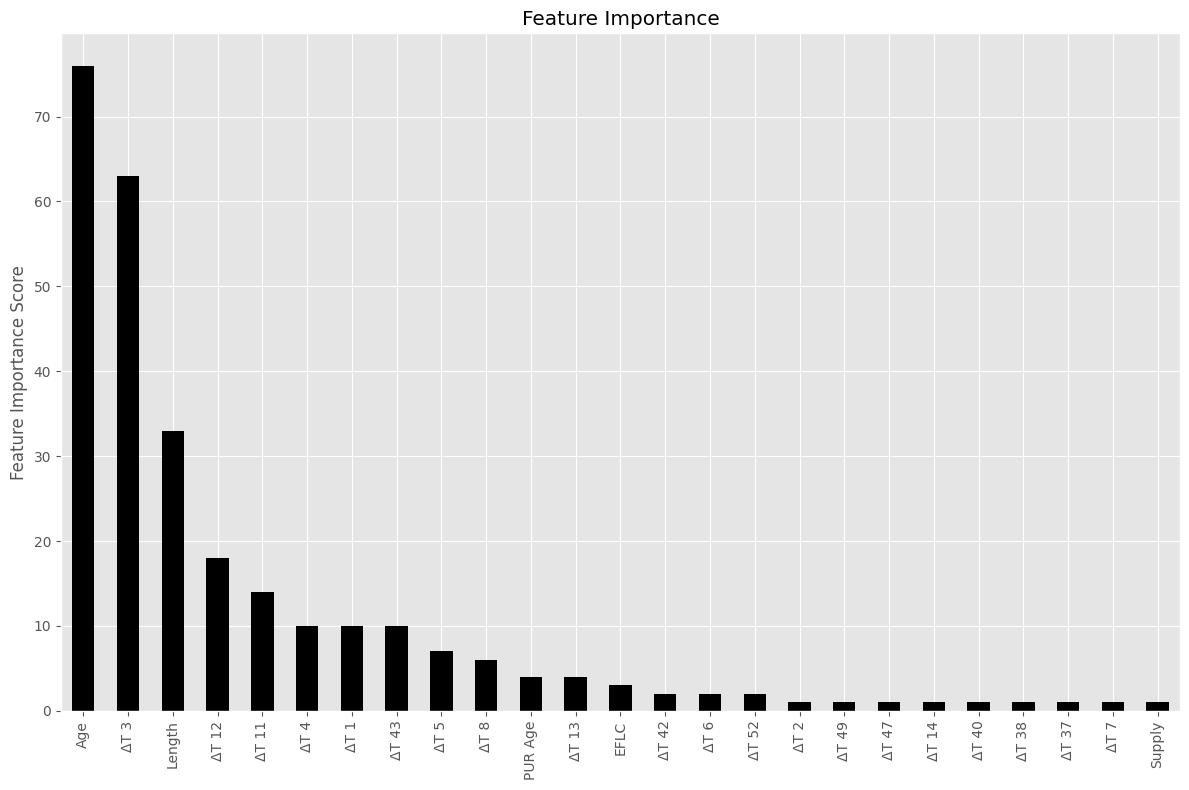

In [43]:
# Visualizing the feature importance
maint_obj.feature_importance()

In [72]:
maint_obj.predict()

TypeError: Maintenance.predict() missing 1 required positional argument: 'data'